In [21]:
import pandas as pd
import numpy as np
import librosa
import random  # For shuffling

# If you are using TensorFlow directly or via Keras (as part of TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [22]:
df = pd.read_csv('dataset_data.csv')

print("Total amount of recordings: ", len(df))

Total amount of recordings:  4395


In [23]:
def extract_mfcc(file_path_row, utterance_length):
    raw_audio, sampling_rate = librosa.load(file_path_row, mono=True)
    # Obtain mfcc features from raw audio
    mfcc_features = librosa.feature.mfcc(y = raw_audio, sr = sampling_rate)

    # Make sure mfcc_features is of utterance length
    if (mfcc_features.shape[1] > utterance_length):
        mfcc_features = mfcc_features[:, 0:utterance_length]
    else:
        mfcc_features = np.pad(mfcc_features, ((0, 0), (0, utterance_length - mfcc_features.shape[1])),
                               mode='constant', constant_values=0)

    return mfcc_features



def get_mfcc_batch(df, batch_size, utterance_length):
    X_batch = []
    Y_batch = []
    # Combine the file paths and labels into a list of tuples
    file_label_pairs = list(zip(df['file_path'].tolist(), df['label'].tolist()))

    while True:
        # Shuffle the pairs instead of individual lists
        np.random.shuffle(file_label_pairs)

        # Iterate through each pair (filename, label)
        for fname, label in file_label_pairs:

            # Extract MFCC Features for the file
            mfcc_features = extract_mfcc(fname, utterance_length)

            # One-hot encode label for 10 digits 0-9
            y = np.eye(10)[int(label)]  # Use the label from the pair

            # Append to label batch
            Y_batch.append(y)

            # Append MFCC features to X_batch
            X_batch.append(mfcc_features)

            # Check to see if default batch size is < than ft_batch
            if len(X_batch) == batch_size:
                # Send over batch
                yield X_batch, Y_batch
                # Reset batches
                X_batch = []
                Y_batch = []

In [24]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, train_size=0.8)
train_df, valid_df = train_test_split(train_df, train_size=0.8)

In [25]:
utterance_length = 20
train_batch = get_mfcc_batch(df, 256, utterance_length)

In [26]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras import metrics
from tensorflow.keras.metrics import Precision, Recall


def LSTMModel(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(256, input_shape=input_shape, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

In [27]:
# Assuming you have confirmed features = 30
input_shape = (30, 30)  # for example, (timesteps, features)
lstm_model = LSTMModel(input_shape)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/Users/dimaevcenko/ml_proj/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
utterance_length = 30
train_batch = get_mfcc_batch(train_df, 600, utterance_length)

In [29]:
from sklearn.preprocessing import StandardScaler

def normalize_features(X):
    # Flatten timesteps and samples together for normalization
    X_reshaped = X.reshape(-1, X.shape[-1])
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X_reshaped)
    X_normalized = X_normalized.reshape(X.shape)
    return X_normalized

def prepare_data(df, utterance_length):
    X = []
    Y = []
    for index, row in df.iterrows():
        # Extract MFCC features
        mfcc_features = extract_mfcc(row['file_path'], utterance_length)
        X.append(mfcc_features)

        # One-hot encode the label
        label = np.eye(10)[int(row['label'])]
        Y.append(label)

    X = np.array(X)
    Y = np.array(Y)

    # Normalize features
    X = normalize_features(X)

    return X, Y


In [30]:
test_X, test_Y = prepare_data(test_df, utterance_length)
train_X, train_Y = prepare_data(train_df, utterance_length)

In [31]:
lstm_model = LSTMModel(input_shape = (30, 30))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Models = []
best_accuracy = 0

for iterations in range(2):
    history = lstm_model.fit(train_X, train_Y, epochs=10, batch_size=200)

    test_loss, test_accuracy = lstm_model.evaluate(test_X, test_Y)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        Models.append(lstm_model)  # Store the best model


Epoch 1/10


/Users/dimaevcenko/ml_proj/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.1384 - loss: 2.2661
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - accuracy: 0.3144 - loss: 1.9773
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step - accuracy: 0.4077 - loss: 1.7531
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - accuracy: 0.5293 - loss: 1.3437
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step - accuracy: 0.5952 - loss: 1.1333
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 476ms/step - accuracy: 0.6232 - loss: 1.0593
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - accuracy: 0.6644 - loss: 0.9899
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.6891 - loss: 0.8702
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 418ms/step - accuracy: 0.7236 - loss: 0.7640
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.7516 - loss: 0.7121
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7229 - loss: 0.8073
Test Loss: 0.8213539123535156, Test Accuracy: 0.7201365232467651
Epoch 1/10

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 515ms/step - accuracy: 0.1512 - loss: 2.2699 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2423 - val_loss: 2.0740 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.2889 - loss: 2.0032 - precision: 0.5286 - recall: 0.0086 - val_accuracy: 0.3970 - val_loss: 1.7379 - val_precision: 0.7920 - val_recall: 0.1126
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 458ms/step - accuracy: 0.4110 - loss: 1.6767 - precision: 0.7863 - recall: 0.1456 - val_accuracy: 0.4778 - val_loss: 1.5212 - val_precision: 0.7000 - val_recall: 0.3265
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - accuracy: 0.5160 - loss: 1.3581 - precision: 0.7471 - recall: 0.3534 - val_accuracy: 0.5870 - val_loss: 1.2091 - val_precision: 0.8025 - val_recall: 0.4391
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.5978 - loss: 1.1562 - precision: 0.7995 - recall: 0.4435 - val_accuracy: 0.59

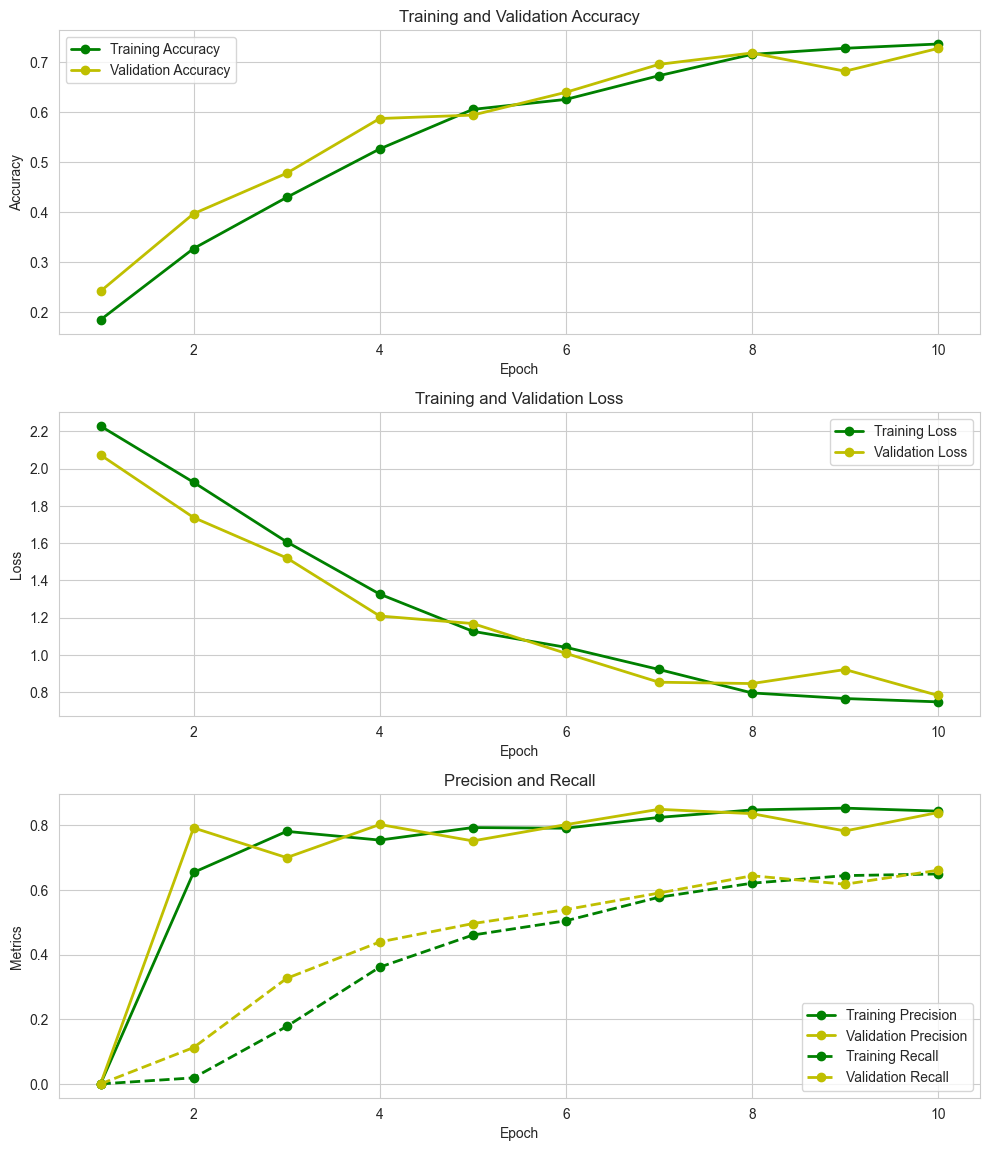

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
F1 Score: 0.7290803922411898
Confusion Matrix:


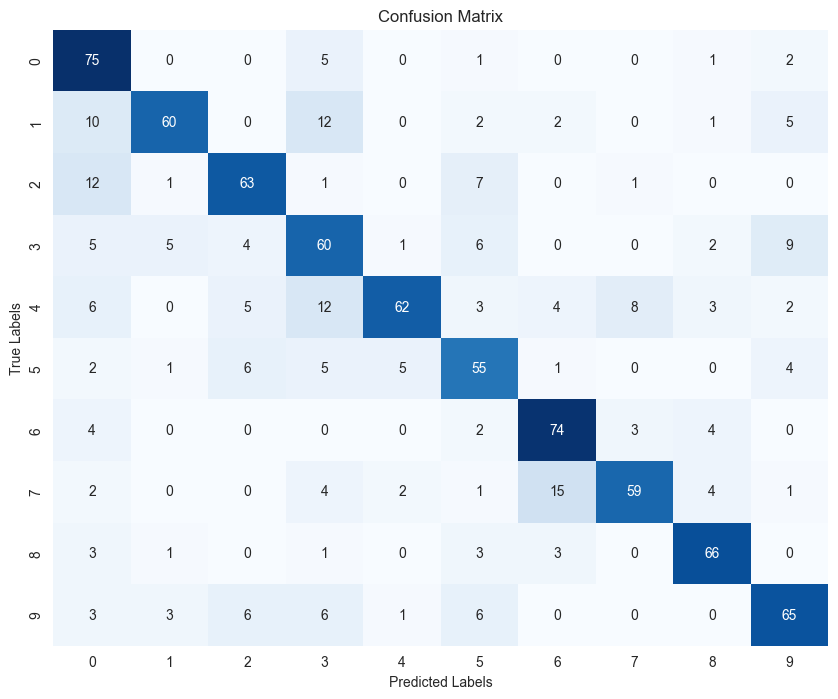

In [32]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_f1_scores(y_true, y_pred):
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
    return f1

def plot_metrics(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(10, 15))

    # Plot training & validation accuracy values
    plt.subplot(411)
    plt.plot(epochs, history.history['accuracy'], 'go-', label='Training Accuracy', linewidth=2)  # Green line
    plt.plot(epochs, history.history['val_accuracy'], 'yo-', label='Validation Accuracy', linewidth=2)  # Yellow line
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training & validation loss values
    plt.subplot(412)
    plt.plot(epochs, history.history['loss'], 'go-', label='Training Loss', linewidth=2)  # Green line
    plt.plot(epochs, history.history['val_loss'], 'yo-', label='Validation Loss', linewidth=2)  # Yellow line
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Precision and Recall
    plt.subplot(413)
    plt.plot(epochs, history.history['precision'], 'go-', label='Training Precision', linewidth=2)  # Green line
    plt.plot(epochs, history.history['val_precision'], 'yo-', label='Validation Precision', linewidth=2)  # Yellow line
    plt.plot(epochs, history.history['recall'], 'go--', label='Training Recall', linewidth=2)  # Green dashed line
    plt.plot(epochs, history.history['val_recall'], 'yo--', label='Validation Recall', linewidth=2)  # Yellow dashed line
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


lstm_model = LSTMModel(input_shape=(30, 30))
history = lstm_model.fit(train_X, train_Y, epochs=10, batch_size=200, validation_data=(test_X, test_Y))

# Calculate and print F1 score
test_predictions = lstm_model.predict(test_X)
f1 = calculate_f1_scores(test_Y, test_predictions)
print(f"F1 Score: {f1}")

# Plot metrics
plot_metrics(history)

test_predictions = lstm_model.predict(test_X)
f1 = calculate_f1_scores(test_Y, test_predictions)
print(f"F1 Score: {f1}")
cm = confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
